In [1]:
import rasterio
import geopandas as gpd
from rasterio.features import geometry_mask
from rasterstats import zonal_stats
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns



In [2]:
import os
os.chdir("G:\\uni class sessions\GEE\sari\exurb\multiscale\sari")  # Change directory to CSV file location


In [3]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from pathlib import Path
import logging
from typing import Dict, Union
import os

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class SpatialDataPreprocessor:
    """
    A class to handle spatial data preprocessing operations including
    reading shapefiles and reprojecting raster data.
    """
    
    def __init__(self, base_shapefile_path: str):
        """
        Initialize the preprocessor with a base shapefile path.
        
        Args:
            base_shapefile_path (str): Path to the base shapefile containing the target CRS
        """
        self.base_shapefile_path = base_shapefile_path
        self.base_gdf = self._load_base_shapefile()
        self.target_crs = self.base_gdf.crs
        
    def _load_base_shapefile(self) -> gpd.GeoDataFrame:
        """
        Load the base shapefile and verify its validity.
        
        Returns:
            gpd.GeoDataFrame: Loaded geodataframe
        """
        try:
            gdf = gpd.read_file(self.base_shapefile_path)
            if gdf.crs is None:
                raise ValueError("Base shapefile has no defined CRS")
            return gdf
        except Exception as e:
            logger.error(f"Error loading base shapefile: {str(e)}")
            raise
            
    def reproject_raster(self, 
                        input_raster_path: str, 
                        output_raster_path: str) -> None:
        """
        Reproject a raster file to match the target CRS.
        
        Args:
            input_raster_path (str): Path to input raster file
            output_raster_path (str): Path where reprojected raster will be saved
        """
        try:
            with rasterio.open(input_raster_path) as src:
                transform, width, height = calculate_default_transform(
                    src.crs, 
                    self.target_crs, 
                    src.width, 
                    src.height, 
                    *src.bounds
                )
                
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': self.target_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
                
                with rasterio.open(output_raster_path, 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=self.target_crs,
                            resampling=Resampling.nearest
                        )
            logger.info(f"Successfully reprojected {input_raster_path}")
        except Exception as e:
            logger.error(f"Error reprojecting raster {input_raster_path}: {str(e)}")
            raise
            
    def batch_reproject_rasters(self, raster_files: Dict[str, str]) -> None:
        """
        Reproject multiple raster files in batch.
        
        Args:
            raster_files (Dict[str, str]): Dictionary mapping input raster paths to output raster paths
        """
        for input_raster, output_raster in raster_files.items():
            if not os.path.exists(input_raster):
                logger.warning(f"Input raster not found: {input_raster}")
                continue
            self.reproject_raster(input_raster, output_raster)

def main():
    # Initialize preprocessor with base shapefile
    preprocessor = SpatialDataPreprocessor('merged_result.shp')
    
    # Define raster files to process
    raster_files = {
        'UHI_Hotspots_new.tif': 'UHI_Hotspots_reprojected_sari.tif',
        'LST_sari_23_new.tif': 'LST_reprojected_sari.tif',
        'UHI_Intensity_new.tif': 'UHI_Intensity_reprojected_sari.tif',
        'NDVI_Sari23.tif': 'NDVI_reprojected_sari.tif'
    }
    
    # Process all rasters
    preprocessor.batch_reproject_rasters(raster_files)

if __name__ == "__main__":
    main()

INFO:__main__:Successfully reprojected UHI_Hotspots_new.tif
INFO:__main__:Successfully reprojected LST_sari_23_new.tif
INFO:__main__:Successfully reprojected UHI_Intensity_new.tif
INFO:__main__:Successfully reprojected NDVI_Sari23.tif


In [4]:
import rasterio
from rasterstats import zonal_stats
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats

class SpatialAggregator:
    def __init__(self, base_dir):
        self.base_dir = Path(base_dir)
        self.raster_files = {
            'UHI_Hotspots_reprojected_sari.tif': 'uhi_hotspots',
            'LST_reprojected_sari.tif': 'lst',
            'UHI_Intensity_reprojected_sari.tif': 'uhi_intensity',
            'NDVI_reprojected_sari.tif': 'ndvi'
        }

    def calculate_zonal_stats(self, raster_path, gdf):
        """Calculate comprehensive zonal statistics including uncertainty metrics."""
        with rasterio.open(raster_path) as src:
            affine = src.transform
            array = src.read(1)
            
        # Calculate statistics
        stats = zonal_stats(
            gdf, 
            array,
            affine=affine,
            stats=['mean', 'median', 'std', 'count', 'min', 'max'],
            nodata=src.nodata
        )
        
        return pd.DataFrame(stats)

    def aggregate_to_level(self, blocks_gdf, target_gdf, id_column, sum_variables, mean_variables):
        """
        Aggregate data to a specific administrative level with uncertainty calculations.
        """
        # Spatial join
        joined = gpd.sjoin(blocks_gdf, target_gdf, how='left', predicate='within')
        
        # Initialize results dictionary
        results = {}
        
        # Process sum variables
        for var in sum_variables:
            if var in joined.columns:
                group_sums = joined.groupby(id_column)[var].sum()
                results[var] = group_sums
                
        # Process mean variables with uncertainty
        for var in mean_variables:
            if var in joined.columns:
                # Calculate statistics for each group
                group_stats = joined.groupby(id_column)[var].agg(['mean', 'std', 'count'])
                
                # Store mean
                results[var] = group_stats['mean']
                
                # Calculate and store uncertainty metrics
                mask = group_stats['count'] > 0
                sem = np.zeros_like(group_stats['mean'])
                sem[mask] = group_stats.loc[mask, 'std'] / np.sqrt(group_stats.loc[mask, 'count'])
                
                results[f"{var}_sem"] = sem
                results[f"{var}_ci_lower"] = group_stats['mean'] - (1.96 * sem)
                results[f"{var}_ci_upper"] = group_stats['mean'] + (1.96 * sem)
                results[f"{var}_count"] = group_stats['count']
        
        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        results_df.index.name = id_column
        results_df = results_df.reset_index()
        
        return results_df

    def process_rasters(self, gdf):
        """Process all raster files with multiple aggregation methods and uncertainty analysis."""
        results = {}
        
        for raster_file, base_name in self.raster_files.items():
            raster_path = self.base_dir / raster_file
            print(f"Processing {raster_file}...")
            
            # Calculate basic statistics
            stats_df = self.calculate_zonal_stats(raster_path, gdf)
            
            # Store results
            for col in stats_df.columns:
                results[f"{base_name}_{col}"] = stats_df[col]
        
        return pd.DataFrame(results)

def process_spatial_data(base_dir):
    """
    Process spatial data and return the final GeoDataFrames instead of saving to files.
    
    Parameters:
    base_dir (str): Base directory containing input files
    
    Returns:
    tuple: (neighborhoods_final, districts_final) - The processed GeoDataFrames
    """
    # Initialize
    BASE_DIR = Path(base_dir)
    aggregator = SpatialAggregator(BASE_DIR)
    
    # Load data
    merged_result = gpd.read_file(BASE_DIR / 'merged_result.shp')
    neighborhoods = gpd.read_file(BASE_DIR / 'neighborhoods_Sari22.shp')
    districts = gpd.read_file(BASE_DIR / 'districts_sari.shp')
    
    # Process rasters with uncertainty
    raster_stats = aggregator.process_rasters(merged_result)
    merged_result = pd.concat([merged_result, raster_stats], axis=1)
    
    # Define variables for aggregation
    sum_variables = [
        'total_pop', 'total_fami', 'residentia', 'boton', 'felez', 'ajor',
        'apartment', 'villaei', 'area_hec_b', 'foundation'
    ]
    mean_variables = [
        'uhi_hotspots_mean', 'lst_mean', 'uhi_intensity_mean', 'ndvi_mean',
        'pop_dens', 'family_den'
    ]
    
    # Aggregate to neighborhood level
    print("Aggregating to neighborhood level...")
    neighborhoods_agg = aggregator.aggregate_to_level(
        merged_result, 
        neighborhoods, 
        'Id',
        sum_variables,
        mean_variables
    )
    
    # Aggregate to district level
    print("Aggregating to district level...")
    districts_agg = aggregator.aggregate_to_level(
        merged_result,
        districts,
        'districtID',
        sum_variables,
        mean_variables
    )
    
    # Merge results back to spatial data
    neighborhoods_final = neighborhoods.merge(neighborhoods_agg, on='Id', how='left')
    districts_final = districts.merge(districts_agg, on='districtID', how='left')
    
    # Generate and save summary statistics (optional)
    summary_stats = pd.DataFrame({
        'level': ['neighborhood', 'district'],
        'count': [len(neighborhoods_final), len(districts_final)],
        'mean_uhi_uncertainty': [
            neighborhoods_final['uhi_intensity_mean_sem'].mean(),
            districts_final['uhi_intensity_mean_sem'].mean()
        ]
    })
    summary_stats.to_csv(BASE_DIR / 'aggregation_summary_stats.csv')
    
    print("Processing completed successfully!")
    return neighborhoods_final, districts_final, merged_result

if __name__ == "__main__":
    # Example usage
    BASE_DIR = r"G:\uni class sessions\GEE\sari\exurb\multiscale\sari"
    neighborhoods_final, districts_final, merged_result = process_spatial_data(BASE_DIR)

Processing UHI_Hotspots_reprojected_sari.tif...


C:\Users\FR\AppData\Local\Programs\Python\Python311\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Processing LST_reprojected_sari.tif...
Processing UHI_Intensity_reprojected_sari.tif...
Processing NDVI_reprojected_sari.tif...
Aggregating to neighborhood level...
Aggregating to district level...
Processing completed successfully!


In [5]:
print(neighborhoods_final.columns.tolist())



['OBJECTID', 'Id', 'name', 'Shape_Leng', 'Shape_Area', 'areahec', 'dnsty_valu', 'neigh_id', 'geometry', 'total_pop', 'total_fami', 'residentia', 'boton', 'felez', 'ajor', 'apartment', 'villaei', 'area_hec_b', 'foundation', 'uhi_hotspots_mean', 'uhi_hotspots_mean_sem', 'uhi_hotspots_mean_ci_lower', 'uhi_hotspots_mean_ci_upper', 'uhi_hotspots_mean_count', 'lst_mean', 'lst_mean_sem', 'lst_mean_ci_lower', 'lst_mean_ci_upper', 'lst_mean_count', 'uhi_intensity_mean', 'uhi_intensity_mean_sem', 'uhi_intensity_mean_ci_lower', 'uhi_intensity_mean_ci_upper', 'uhi_intensity_mean_count', 'ndvi_mean', 'ndvi_mean_sem', 'ndvi_mean_ci_lower', 'ndvi_mean_ci_upper', 'ndvi_mean_count', 'pop_dens', 'pop_dens_sem', 'pop_dens_ci_lower', 'pop_dens_ci_upper', 'pop_dens_count', 'family_den', 'family_den_sem', 'family_den_ci_lower', 'family_den_ci_upper', 'family_den_count']


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np
from pathlib import Path
import contextily as ctx
import folium
from matplotlib.colors import LinearSegmentedColormap

class UncertaintyVisualizer:
    """
    A class to create visualizations for spatial uncertainty analysis.
    """
    def __init__(self, output_dir):
        """
        Initialize the visualizer with an output directory for plots.
        
        Parameters:
        output_dir (str or Path): Directory where visualization outputs will be saved
        """
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        # Custom color schemes
        self.uncertainty_colors = ['#2ecc71', '#f1c40f', '#e74c3c']
        self.uncertainty_cmap = LinearSegmentedColormap.from_list('uncertainty', 
                                                                self.uncertainty_colors)
    
    def plot_uncertainty_maps(self, gdf, value_column, uncertainty_column, 
                            title, filename, figsize=(15, 10)):
        """
        Create side-by-side maps showing the main value and its uncertainty.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot main value
        gdf.plot(column=value_column, 
                ax=ax1, 
                legend=True,
                legend_kwds={'label': value_column},
                cmap='viridis')
        ax1.set_title(f'{title} Values')
        ax1.axis('off')
        
        # Plot uncertainty
        gdf.plot(column=uncertainty_column,
                ax=ax2,
                legend=True,
                legend_kwds={'label': 'Uncertainty (SEM)'},
                cmap=self.uncertainty_cmap)
        ax2.set_title(f'{title} Uncertainty')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.savefig(self.output_dir / f'{filename}_uncertainty_maps.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()

    def create_uncertainty_violin_plot(self, gdf, value_columns, 
                                     uncertainty_columns, filename):
        """
        Create violin plots showing value distributions and uncertainties.
        """
        plt.figure(figsize=(12, 6))
        
        data_to_plot = []
        labels = []
        
        for val_col, unc_col in zip(value_columns, uncertainty_columns):
            mean_vals = gdf[val_col]
            uncertainties = gdf[unc_col]
            
            # Create range of possible values based on uncertainty
            lower_bound = mean_vals - uncertainties
            upper_bound = mean_vals + uncertainties
            
            data_to_plot.append(np.concatenate([lower_bound, upper_bound]))
            labels.extend([val_col] * len(lower_bound) * 2)
        
        sns.violinplot(data=data_to_plot)
        plt.xticks(range(len(value_columns)), value_columns, rotation=45)
        plt.title('Distribution of Values with Uncertainty')
        plt.tight_layout()
        plt.savefig(self.output_dir / f'{filename}_violin_plots.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()

    def plot_uncertainty_histogram(self, gdf, value_column, uncertainty_column, 
                                 filename):
        """
        Create histogram showing the distribution of uncertainties.
        """
        plt.figure(figsize=(10, 6))
        
        # Calculate coefficient of variation
        cv = (gdf[uncertainty_column] / gdf[value_column]).abs()
        
        sns.histplot(cv, bins=30)
        plt.axvline(cv.mean(), color='r', linestyle='--', 
                   label=f'Mean CV: {cv.mean():.3f}')
        plt.title(f'Distribution of Uncertainty (CV) for {value_column}')
        plt.xlabel('Coefficient of Variation')
        plt.ylabel('Count')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(self.output_dir / f'{filename}_uncertainty_histogram.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()

    def create_confidence_interval_plot(self, gdf, value_column, ci_lower_column, 
                                      ci_upper_column, filename):
        """
        Create a plot showing mean values with confidence intervals.
        """
        plt.figure(figsize=(12, 6))
        
        # Sort values for better visualization
        sorted_indices = gdf[value_column].sort_values().index
        x = range(len(gdf))
        y = gdf.loc[sorted_indices, value_column]
        ci_lower = gdf.loc[sorted_indices, ci_lower_column]
        ci_upper = gdf.loc[sorted_indices, ci_upper_column]
        
        plt.plot(x, y, 'b-', label='Mean Value')
        plt.fill_between(x, ci_lower, ci_upper, color='b', alpha=0.2, 
                        label='95% Confidence Interval')
        
        plt.title(f'Mean Values with Confidence Intervals: {value_column}')
        plt.xlabel('Area Index (sorted by value)')
        plt.ylabel('Value')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(self.output_dir / f'{filename}_confidence_intervals.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()

    def create_spatial_reliability_map(self, gdf, value_column, uncertainty_column, 
                                     filename):
        """
        Create a map showing data reliability based on uncertainty levels.
        """
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Calculate reliability score (inverse of coefficient of variation)
        reliability = 1 / ((gdf[uncertainty_column] / gdf[value_column]).abs())
        reliability = (reliability - reliability.min()) / (reliability.max() - reliability.min())
        
        gdf.plot(column=reliability,
                ax=ax,
                legend=True,
                legend_kwds={'label': 'Reliability Score'},
                cmap=self.uncertainty_cmap)
        
        plt.title('Spatial Data Reliability Map')
        ax.axis('off')
        
        plt.tight_layout()
        plt.savefig(self.output_dir / f'{filename}_reliability_map.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()

def create_uncertainty_visualizations(neighborhoods_final, districts_final, output_dir):
    """
    Create visualizations for both neighborhood and district level data.
    
    Parameters:
    neighborhoods_final (GeoDataFrame): Processed neighborhood level data
    districts_final (GeoDataFrame): Processed district level data
    output_dir (str or Path): Directory to save visualization outputs
    """
    # Initialize visualizer
    visualizer = UncertaintyVisualizer(output_dir)
    
    # Variables to visualize
    value_columns = ['uhi_intensity_mean', 'lst_mean', 'ndvi_mean']
    uncertainty_columns = ['uhi_intensity_mean_sem', 'lst_mean_sem', 'ndvi_mean_sem']
    
    # Create visualizations for neighborhoods
    for val_col, unc_col in zip(value_columns, uncertainty_columns):
        # Create uncertainty maps
        visualizer.plot_uncertainty_maps(
            neighborhoods_final, val_col, unc_col,
            'Neighborhood ' + val_col,
            f'neighborhood_{val_col}'
        )
        
        # Create uncertainty histograms
        visualizer.plot_uncertainty_histogram(
            neighborhoods_final, val_col, unc_col,
            f'neighborhood_{val_col}'
        )
        
        # Create confidence interval plots
        ci_lower = f"{val_col}_ci_lower"
        ci_upper = f"{val_col}_ci_upper"
        visualizer.create_confidence_interval_plot(
            neighborhoods_final, val_col, ci_lower, ci_upper,
            f'neighborhood_{val_col}'
        )
        
        # Create reliability maps
        visualizer.create_spatial_reliability_map(
            neighborhoods_final, val_col, unc_col,
            f'neighborhood_{val_col}'
        )
    
    # Create violin plots for all variables
    visualizer.create_uncertainty_violin_plot(
        neighborhoods_final, value_columns, uncertainty_columns,
        'neighborhood_all_variables'
    )
    
    # Repeat for districts
    for val_col, unc_col in zip(value_columns, uncertainty_columns):
        visualizer.plot_uncertainty_maps(
            districts_final, val_col, unc_col,
            'District ' + val_col,
            f'district_{val_col}'
        )
        
        visualizer.plot_uncertainty_histogram(
            districts_final, val_col, unc_col,
            f'district_{val_col}'
        )
        
        ci_lower = f"{val_col}_ci_lower"
        ci_upper = f"{val_col}_ci_upper"
        visualizer.create_confidence_interval_plot(
            districts_final, val_col, ci_lower, ci_upper,
            f'district_{val_col}'
        )
        
        visualizer.create_spatial_reliability_map(
            districts_final, val_col, unc_col,
            f'district_{val_col}'
        )
    
    visualizer.create_uncertainty_violin_plot(
        districts_final, value_columns, uncertainty_columns,
        'district_all_variables'
    )

if __name__ == "__main__":
    # Example usage with the GeoDataFrames from the previous code
    BASE_DIR = Path(r"G:\uni class sessions\GEE\sari\exurb\multiscale\sari")
    
    # First get the processed GeoDataFrames
    neighborhoods_final, districts_final, merged_result = process_spatial_data(BASE_DIR)
    
    # Create visualizations
    output_dir = BASE_DIR / 'uncertainty_plots'
    create_uncertainty_visualizations(neighborhoods_final, districts_final, output_dir)

Processing UHI_Hotspots_reprojected_sari.tif...
Processing LST_reprojected_sari.tif...
Processing UHI_Intensity_reprojected_sari.tif...
Processing NDVI_reprojected_sari.tif...
Aggregating to neighborhood level...
Aggregating to district level...
Processing completed successfully!


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


In [8]:
print(neighborhoods_final.columns.tolist())
print (neighborhoods_final['lst_mean'].values)

['OBJECTID', 'Id', 'name', 'Shape_Leng', 'Shape_Area', 'areahec', 'dnsty_valu', 'neigh_id', 'geometry', 'total_pop', 'total_fami', 'residentia', 'boton', 'felez', 'ajor', 'apartment', 'villaei', 'area_hec_b', 'foundation', 'uhi_hotspots_mean', 'uhi_hotspots_mean_sem', 'uhi_hotspots_mean_ci_lower', 'uhi_hotspots_mean_ci_upper', 'uhi_hotspots_mean_count', 'lst_mean', 'lst_mean_sem', 'lst_mean_ci_lower', 'lst_mean_ci_upper', 'lst_mean_count', 'uhi_intensity_mean', 'uhi_intensity_mean_sem', 'uhi_intensity_mean_ci_lower', 'uhi_intensity_mean_ci_upper', 'uhi_intensity_mean_count', 'ndvi_mean', 'ndvi_mean_sem', 'ndvi_mean_ci_lower', 'ndvi_mean_ci_upper', 'ndvi_mean_count', 'pop_dens', 'pop_dens_sem', 'pop_dens_ci_lower', 'pop_dens_ci_upper', 'pop_dens_count', 'family_den', 'family_den_sem', 'family_den_ci_lower', 'family_den_ci_upper', 'family_den_count']
[49.67067624 49.09624555 49.67988338 49.61861295 49.51410577 49.94099388
 45.12238494 49.6537586  48.46245828 48.54123546 48.97765732 48.11

In [9]:
def diagnose_data_issues(data, scale_name):
    """
    Diagnose potential issues in the dataset that might cause NaN correlations.
    
    Args:
        data (pd.DataFrame): Dataset to analyze
        scale_name (str): Name of the spatial scale for labeling
    """
    print(f"\n=== Diagnostic Report for {scale_name} Scale ===")
    
    # Check 1: Missing values
    missing_counts = data.isnull().sum()
    if missing_counts.any():
        print("\n1. Columns with missing values:")
        print(missing_counts[missing_counts > 0])
    else:
        print("\n1. No missing values found in any column")
    
    # Check 2: Zero or constant values
    constant_cols = []
    zero_cols = []
    for col in data.columns:
        if data[col].nunique() == 1:
            constant_cols.append(col)
        if (data[col] == 0).all():
            zero_cols.append(col)
    
    if constant_cols:
        print("\n2. Columns with constant values:")
        print(constant_cols)
    if zero_cols:
        print("\n3. Columns containing all zeros:")
        print(zero_cols)
    
    # Check 3: Data types and infinite values
    print("\n4. Data types of columns:")
    print(data.dtypes)
    
    inf_cols = []
    for col in data.select_dtypes(include=np.number).columns:
        if np.isinf(data[col]).any():
            inf_cols.append(col)
    
    if inf_cols:
        print("\n5. Columns containing infinite values:")
        print(inf_cols)
    
    # Check 4: Basic statistics
    print("\n6. Basic statistics for numeric columns:")
    print(data.describe())
    
    # Check 5: Column presence
    expected_columns = [
        'total_pop', 'total_fami', 'residentia', 'boton', 'felez', 'ajor',
        'apartment', 'villaei', 'pop_dens', 'family_den', 'area_hec_b',
        'foundation', 'uhi_hotspots_mean', 'lst_mean', 'uhi_intensity_mean',
        'ndvi_mean'
    ]
    
    missing_cols = [col for col in expected_columns if col not in data.columns]
    if missing_cols:
        print("\n7. Expected columns that are missing:")
        print(missing_cols)

def fix_data_issues(data):
    """
    Attempt to fix common data issues that might cause NaN correlations.
    
    Args:
        data (pd.DataFrame): Dataset to fix
        
    Returns:
        pd.DataFrame: Fixed dataset
    """
    # Create a copy to avoid modifying the original
    fixed_data = data.copy()
    
    # 1. Replace infinite values with NaN
    fixed_data = fixed_data.replace([np.inf, -np.inf], np.nan)
    
    # 2. Drop rows where all numeric columns are NaN
    fixed_data = fixed_data.dropna(how='all', subset=fixed_data.select_dtypes(include=np.number).columns)
    
    # 3. For remaining NaN values, use column median
    numeric_cols = fixed_data.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        fixed_data[col] = fixed_data[col].fillna(fixed_data[col].median())
    
    # 4. Convert any string columns that should be numeric
    for col in fixed_data.columns:
        if fixed_data[col].dtype == 'O':  # Object dtype usually means strings
            try:
                fixed_data[col] = pd.to_numeric(fixed_data[col], errors='coerce')
            except:
                continue
    
    return fixed_data

# Usage example:
def analyze_and_fix_neighborhood_data(neighborhoods_final):
    """
    Analyze and fix neighborhood scale data issues.
    
    Args:
        neighborhoods_final (pd.DataFrame): Neighborhood scale dataset
        
    Returns:
        pd.DataFrame: Fixed dataset
    """
    print("Running diagnostics on original data...")
    diagnose_data_issues(neighborhoods_final, "Neighborhood")
    
    print("\nAttempting to fix data issues...")
    fixed_data = fix_data_issues(neighborhoods_final)
    
    print("\nRunning diagnostics on fixed data...")
    diagnose_data_issues(fixed_data, "Neighborhood")
    
    return fixed_data


neighborhoods_final = analyze_and_fix_neighborhood_data(neighborhoods_final)


Running diagnostics on original data...

=== Diagnostic Report for Neighborhood Scale ===

1. No missing values found in any column

4. Data types of columns:
OBJECTID                          int64
Id                                int64
name                             object
Shape_Leng                      float64
Shape_Area                      float64
areahec                         float64
dnsty_valu                      float64
neigh_id                          int64
geometry                       geometry
total_pop                       float64
total_fami                      float64
residentia                      float64
boton                           float64
felez                           float64
ajor                            float64
apartment                       float64
villaei                         float64
area_hec_b                      float64
foundation                      float64
uhi_hotspots_mean               float64
uhi_hotspots_mean_sem           float64
u

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

def compute_correlations_with_uncertainty(data, scale_name, output_dir):
    """
    Compute and visualize correlation matrix with uncertainty considerations.
    
    Args:
        data (pd.DataFrame): Dataset to analyze
        scale_name (str): Name of the spatial scale for labeling
        output_dir (Path): Directory to save outputs
    """
    # Define columns of interest for correlation analysis
    base_columns = [
        'total_pop', 'total_fami', 'residentia', 'boton', 'felez', 'ajor', 
        'apartment', 'villaei', 'pop_dens', 'family_den', 'area_hec_b', 
        'foundation', 'uhi_hotspots_mean', 'lst_mean', 'uhi_intensity_mean', 
        'ndvi_mean'
    ]
    
    # Add uncertainty columns for relevant variables
    uncertainty_pairs = {
        'uhi_hotspots_mean': 'uhi_hotspots_mean_sem',
        'lst_mean': 'lst_mean_sem',
        'uhi_intensity_mean': 'uhi_intensity_mean_sem',
        'ndvi_mean': 'ndvi_mean_sem'
    }
    
    # Compute weighted correlation matrix considering uncertainties
    correlation_matrix = data[base_columns].corr()
    
    # Weight correlations by reliability (inverse of uncertainty)
    for var, uncertainty_col in uncertainty_pairs.items():
        if var in correlation_matrix.columns and uncertainty_col in data.columns:
            # Calculate reliability weights (inverse of relative uncertainty)
            weights = 1 / (data[uncertainty_col] / data[var].abs())
            weights = weights / weights.sum()  # Normalize weights
            
            # Apply weights to correlations
            for other_var in correlation_matrix.columns:
                if other_var != var:
                    weighted_corr = np.corrcoef(
                        data[var] * weights,
                        data[other_var] * weights
                    )[0, 1]
                    correlation_matrix.loc[var, other_var] = weighted_corr
                    correlation_matrix.loc[other_var, var] = weighted_corr
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                fmt=".2f",
                center=0)
    plt.title(f"Uncertainty-Weighted Correlation Matrix at {scale_name} Scale")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save outputs
    plt.savefig(output_dir / f'correlation_heatmap_{scale_name.lower()}.png', 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    correlation_matrix.to_csv(output_dir / f'correlation_matrix_{scale_name.lower()}.csv')
    
    return correlation_matrix

def analyze_scale_dependencies(corr_blocks, corr_neighborhoods, corr_districts, output_dir):
    """
    Analyze how correlations change across spatial scales.
    
    Args:
        corr_blocks, corr_neighborhoods, corr_districts: Correlation matrices
        output_dir (Path): Directory to save outputs
    """
    environmental_vars = ['uhi_hotspots_mean', 'lst_mean', 'uhi_intensity_mean', 'ndvi_mean']
    urban_vars = ['pop_dens', 'family_den', 'area_hec_b', 'foundation']
    
    # Create scale comparison plots
    for env_var in environmental_vars:
        plt.figure(figsize=(10, 6))
        
        scales = ['Block', 'Neighborhood', 'District']
        correlations = []
        
        for urb_var in urban_vars:
            block_corr = corr_blocks.loc[env_var, urb_var]
            neigh_corr = corr_neighborhoods.loc[env_var, urb_var]
            dist_corr = corr_districts.loc[env_var, urb_var]
            
            correlations.append([block_corr, neigh_corr, dist_corr])
        
        # Plot scale dependencies
        for i, urb_var in enumerate(urban_vars):
            plt.plot(scales, correlations[i], 'o-', label=urb_var)
        
        plt.title(f'Scale Dependency of Correlations: {env_var}')
        plt.xlabel('Spatial Scale')
        plt.ylabel('Correlation Coefficient')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        plt.savefig(output_dir / f'scale_dependency_{env_var}.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()

def print_strongest_correlations(corr_matrix, scale_name, n=5):
    """Print the n strongest correlations for each environmental variable."""
    env_vars = ['uhi_hotspots_mean', 'lst_mean', 'uhi_intensity_mean', 'ndvi_mean']
    
    print(f"\nStrongest correlations at {scale_name} scale:")
    for env_var in env_vars:
        correlations = corr_matrix[env_var].abs().sort_values(ascending=False)
        correlations = correlations[correlations.index != env_var]  # Remove self-correlation
        print(f"\n{env_var} correlates strongest with:")
        for var, corr in correlations[:n].items():
            print(f"{var}: {corr_matrix.loc[env_var, var]:.3f}")

def perform_correlation_analysis(merged_result, neighborhoods_final, districts_final, output_dir):
    """
    Perform comprehensive correlation analysis across all spatial scales.
    
    Args:
        merged_result (GeoDataFrame): Block level data
        neighborhoods_final (GeoDataFrame): Neighborhood level data
        districts_final (GeoDataFrame): District level data
        output_dir (Path): Directory to save outputs
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Compute correlations at each scale
    print("\nComputing uncertainty-weighted correlations at Block scale...")
    corr_blocks = compute_correlations_with_uncertainty(merged_result, "Block", output_dir)
    
    print("Computing uncertainty-weighted correlations at Neighborhood scale...")
    corr_neighborhoods = compute_correlations_with_uncertainty(neighborhoods_final, "Neighborhood", output_dir)
    
    print("Computing uncertainty-weighted correlations at District scale...")
    corr_districts = compute_correlations_with_uncertainty(districts_final, "District", output_dir)
    
    # Analyze scale dependencies
    analyze_scale_dependencies(corr_blocks, corr_neighborhoods, corr_districts, output_dir)
    
    # Print summaries for each scale
    for corr_matrix, scale in zip([corr_blocks, corr_neighborhoods, corr_districts], 
                                ['Block', 'Neighborhood', 'District']):
        print_strongest_correlations(corr_matrix, scale)
    
    return corr_blocks, corr_neighborhoods, corr_districts

if __name__ == "__main__":
    # Example usage
    BASE_DIR = Path(r"G:\uni class sessions\GEE\sari\exurb\multiscale\sari")
    
    # First get the processed GeoDataFrames
    neighborhoods_final, districts_final, merged_result = process_spatial_data(BASE_DIR)
    
    # Read block-level data
    #merged_result = gpd.read_file(BASE_DIR / 'merged_result.shp')
    
    # Perform correlation analysis
    output_dir = BASE_DIR / 'correlation_analysis'
    correlation_results = perform_correlation_analysis(
        merged_result, 
        neighborhoods_final, 
        districts_final, 
        output_dir
    )

Processing UHI_Hotspots_reprojected_sari.tif...
Processing LST_reprojected_sari.tif...
Processing UHI_Intensity_reprojected_sari.tif...
Processing NDVI_reprojected_sari.tif...
Aggregating to neighborhood level...
Aggregating to district level...
Processing completed successfully!

Computing uncertainty-weighted correlations at Block scale...
Computing uncertainty-weighted correlations at Neighborhood scale...
Computing uncertainty-weighted correlations at District scale...

Strongest correlations at Block scale:

uhi_hotspots_mean correlates strongest with:
uhi_intensity_mean: 0.743
lst_mean: 0.743
ajor: 0.160
apartment: -0.144
villaei: 0.133

lst_mean correlates strongest with:
uhi_intensity_mean: 1.000
uhi_hotspots_mean: 0.743
ndvi_mean: -0.314
area_hec_b: -0.190
family_den: 0.188

uhi_intensity_mean correlates strongest with:
lst_mean: 1.000
uhi_hotspots_mean: 0.743
ndvi_mean: -0.314
area_hec_b: -0.190
family_den: 0.188

ndvi_mean correlates strongest with:
family_den: -0.495
pop_de

In [11]:
import libpysal
print(libpysal.__version__)

4.12.1


In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

# Base directory for saving outputs
BASE_DIR = Path(r"G:\uni class sessions\GEE\sari\exurb\multiscale")

def calculate_vif(gdf, scale_name):
    """
    Calculate VIF with improved reporting and visualization.
    """
    X = gdf[['total_pop', 'total_fami', 'residentia', 'boton', 'felez', 'ajor', 'apartment',
             'villaei', 'pop_dens', 'family_den', 'area_hec_b', 'foundation', 'ndvi_mean']]
    
    # Handle missing and infinite values before scaling
    X = X.replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
    X = X.fillna(X.mean())  # Fill NaN with mean values
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    
    # Save VIF results with visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(x='VIF', y='Feature', data=vif_data.sort_values('VIF'))
    plt.title(f'VIF Values for {scale_name} Scale')
    plt.savefig(BASE_DIR / f'vif_plot_{scale_name.lower()}.png')
    plt.close()
    
    vif_data.to_csv(BASE_DIR / f'vif_results_{scale_name.lower()}.csv', index=False)
    return vif_data[vif_data['VIF'] <= 20]['Feature'].tolist()

def feature_importance_stability(model, X, y, n_iterations=10):
    """
    Analyze feature importance stability across multiple iterations.
    """
    importance_scores = []
    
    for _ in range(n_iterations):
        # Randomly sample 80% of the data
        indices = np.random.choice(len(X), size=int(0.8 * len(X)), replace=False)
        X_sample = X.iloc[indices]
        y_sample = y.iloc[indices]
        
        # Fit model and get feature importance
        model.fit(X_sample, y_sample)
        
        # Use permutation importance for more robust feature importance
        perm_importance = permutation_importance(model, X_sample, y_sample, n_repeats=10)
        importance_scores.append(perm_importance.importances_mean)
    
    # Calculate stability metrics
    importance_df = pd.DataFrame(importance_scores, columns=X.columns)
    stability_metrics = pd.DataFrame({
        'Feature': X.columns,
        'Mean_Importance': importance_df.mean(),
        'Std_Importance': importance_df.std(),
        'CV': importance_df.std() / importance_df.mean() * 100  # Coefficient of variation
    }).sort_values('Mean_Importance', ascending=False)
    
    return stability_metrics

def optimize_hyperparameters(X, y, model_type='rf'):
    """
    Perform hyperparameter optimization using GridSearchCV.
    """
    if model_type == 'rf':
        model = RandomForestRegressor()
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    else:  # GradientBoosting
        model = GradientBoostingRegressor()
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5, 10]
        }
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_, grid_search.best_params_

def run_machine_learning(gdf, scale_name, selected_vars, y_var='uhi_intensity_mean'):
    """
    Enhanced machine learning pipeline with cross-validation and ensemble methods.
    """
    X = gdf[selected_vars]
    y = gdf[y_var]
    
    # Handle missing values
    X.fillna(0, inplace=True)
    y.fillna(0, inplace=True)
    
    # Initialize cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Optimize hyperparameters for both models
    rf_model, rf_params = optimize_hyperparameters(X, y, 'rf')
    gb_model, gb_params = optimize_hyperparameters(X, y, 'gb')
    
    # Train both models with optimal parameters
    models = {
        'RandomForest': rf_model,
        'GradientBoosting': gb_model
    }
    
    results = {}
    for model_name, model in models.items():
        # Perform cross-validation
        cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
        mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
        
        # Feature importance stability analysis
        stability_metrics = feature_importance_stability(model, X, y)
        
        # Store results
        results[model_name] = {
            'cv_r2_mean': cv_scores.mean(),
            'cv_r2_std': cv_scores.std(),
            'cv_mse_mean': mse_scores.mean(),
            'cv_mse_std': mse_scores.std(),
            'feature_stability': stability_metrics
        }
        
        # Save feature importance stability results
        stability_metrics.to_csv(BASE_DIR / f'{model_name.lower()}_feature_stability_{scale_name.lower()}.csv')
        
        # Visualize feature importance stability
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Mean_Importance', y='Feature', data=stability_metrics)
        plt.title(f'{model_name} Feature Importance Stability ({scale_name} Scale)')
        plt.savefig(BASE_DIR / f'{model_name.lower()}_importance_{scale_name.lower()}.png')
        plt.close()
    
    return results

def analyze_all_scales(merged_result, neighborhoods_final):
    """
    Run the complete analysis pipeline for all scales.
    """
    datasets = {
        'Block': merged_result,
        'Neighborhood': neighborhoods_final
    }
    
    final_results = {}
    for scale_name, dataset in datasets.items():
        print(f"\nAnalyzing {scale_name} scale...")
        
        # VIF analysis
        selected_vars = calculate_vif(dataset, scale_name)
        
        # Machine learning analysis
        ml_results = run_machine_learning(dataset, scale_name, selected_vars)
        
        final_results[scale_name] = {
            'selected_variables': selected_vars,
            'ml_results': ml_results
        }
        
        # Save comprehensive results
        with open(BASE_DIR / f'analysis_results_{scale_name.lower()}.txt', 'w') as f:
            f.write(f"Analysis Results for {scale_name} Scale\n")
            f.write("=" * 50 + "\n\n")
            f.write("Selected Variables after VIF:\n")
            f.write(", ".join(selected_vars) + "\n\n")
            
            for model_name, results in ml_results.items():
                f.write(f"\n{model_name} Results:\n")
                f.write(f"Mean R² (CV): {results['cv_r2_mean']:.4f} ± {results['cv_r2_std']:.4f}\n")
                f.write(f"Mean MSE (CV): {results['cv_mse_mean']:.4f} ± {results['cv_mse_std']:.4f}\n")
    
    return final_results

# Run the complete analysis
final_results = analyze_all_scales(merged_result, neighborhoods_final)


Analyzing Block scale...


C:\Users\FR\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\FR\AppData\Local\Temp\ipykernel_368\1331665729.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)



Analyzing Neighborhood scale...


C:\Users\FR\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\FR\AppData\Local\Temp\ipykernel_368\1331665729.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)



Calculating VIF for Block scale...


C:\Users\FR\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF Results for Block scale:
                 Feature           VIF
0             Value__lef  4.295299e+09
1                 BlkAbd  1.167764e+00
2             Shape_Area  6.872438e+08
3              total_pop  1.908875e+09
4             total_fami  1.908715e+09
5             residentia  1.717993e+10
6                  boton  3.336705e+01
7                  felez  2.528497e+01
8                   ajor  6.203193e+00
9              apartment  2.251800e+14
10               villaei  2.749000e+09
11              pop_dens           inf
12            family_den  4.882030e+01
13            index_righ  9.511628e+08
14              OBJECTID  9.511628e+08
15            Value__rig  1.073605e+09
16                   pop  2.684378e+08
17            area_hec_b  7.635103e+09
18            family_tot  1.419799e+08
19            foundation  1.031496e+02
20               tarakom           inf
21            tarakom_fa  3.101779e+00
22            tarakom__1  3.424776e+01
23            tarakom_po  2.506712

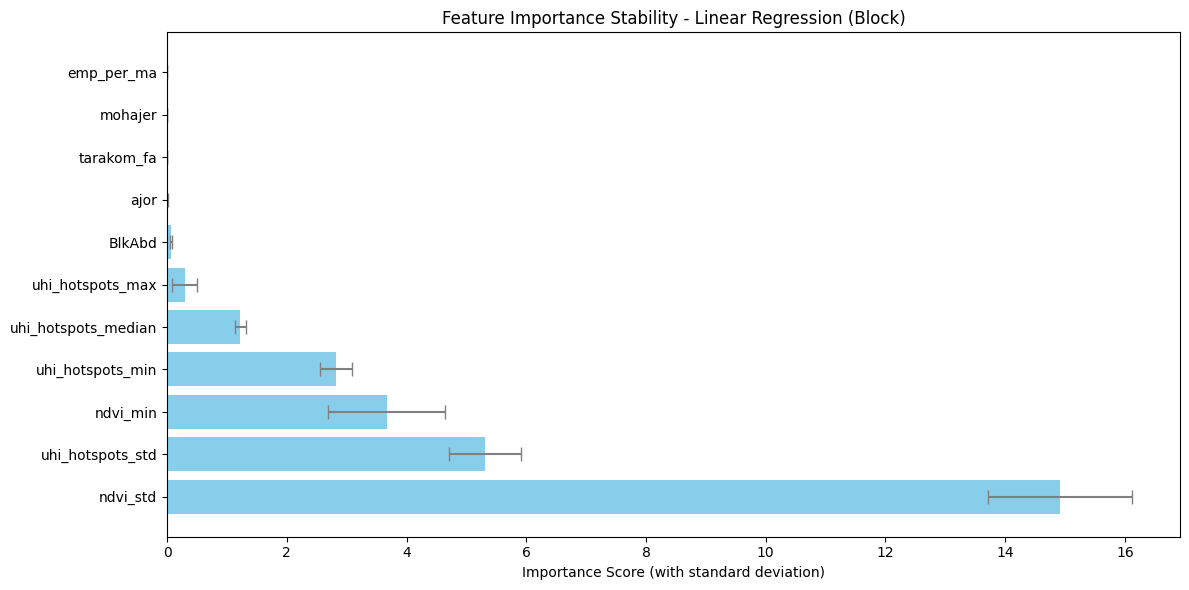


Model: Random Forest, Scale: Block
Cross-validation Results:
CV R² Score: 0.7996 (±0.0298)
CV MSE: 1.4018 (±0.2075)

Test Set Results:
Test MSE: 0.9659
Test R² Score: 0.8691

Future Data Results:
Future MSE: 1.3264
Future R² Score: 0.8223


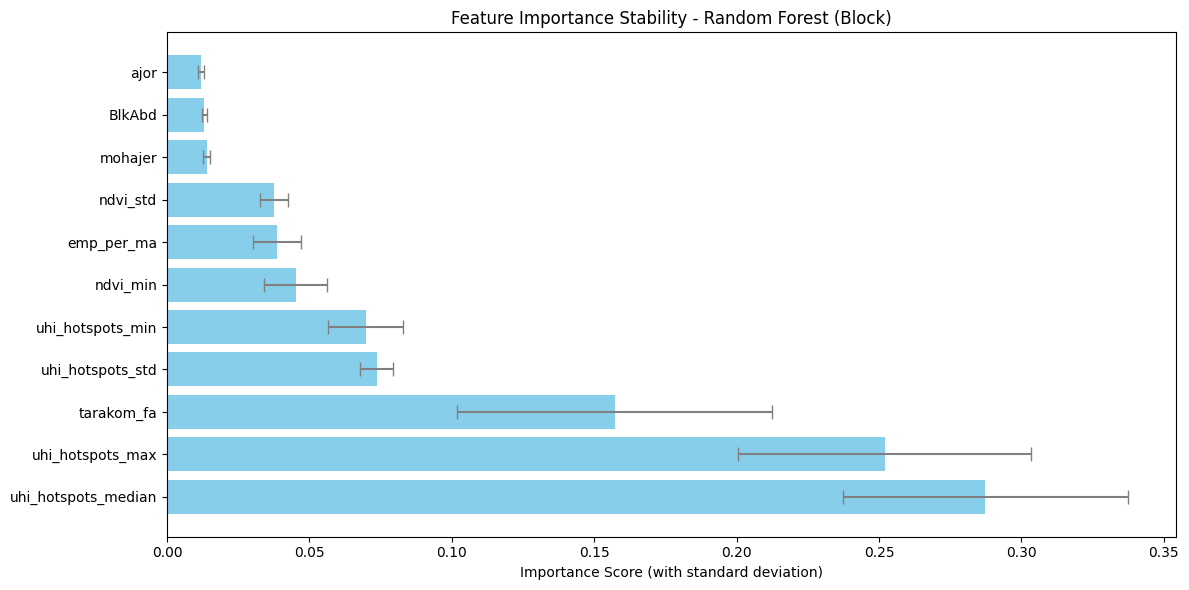


Model: XGBoost, Scale: Block
Cross-validation Results:
CV R² Score: 0.7781 (±0.0374)
CV MSE: 1.5512 (±0.2615)

Test Set Results:
Test MSE: 1.3858
Test R² Score: 0.8122

Future Data Results:
Future MSE: 1.4748
Future R² Score: 0.8024


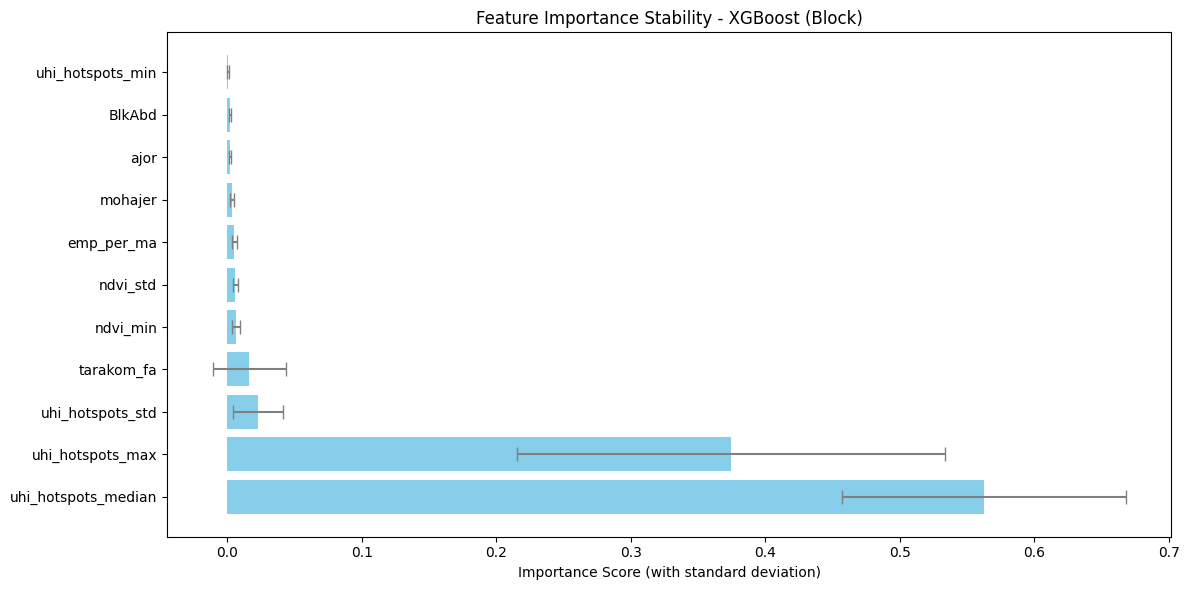


Model: Gradient Boosting, Scale: Block
Cross-validation Results:
CV R² Score: 0.8144 (±0.0316)
CV MSE: 1.2969 (±0.2160)

Test Set Results:
Test MSE: 1.0928
Test R² Score: 0.8519

Future Data Results:
Future MSE: 1.3158
Future R² Score: 0.8237


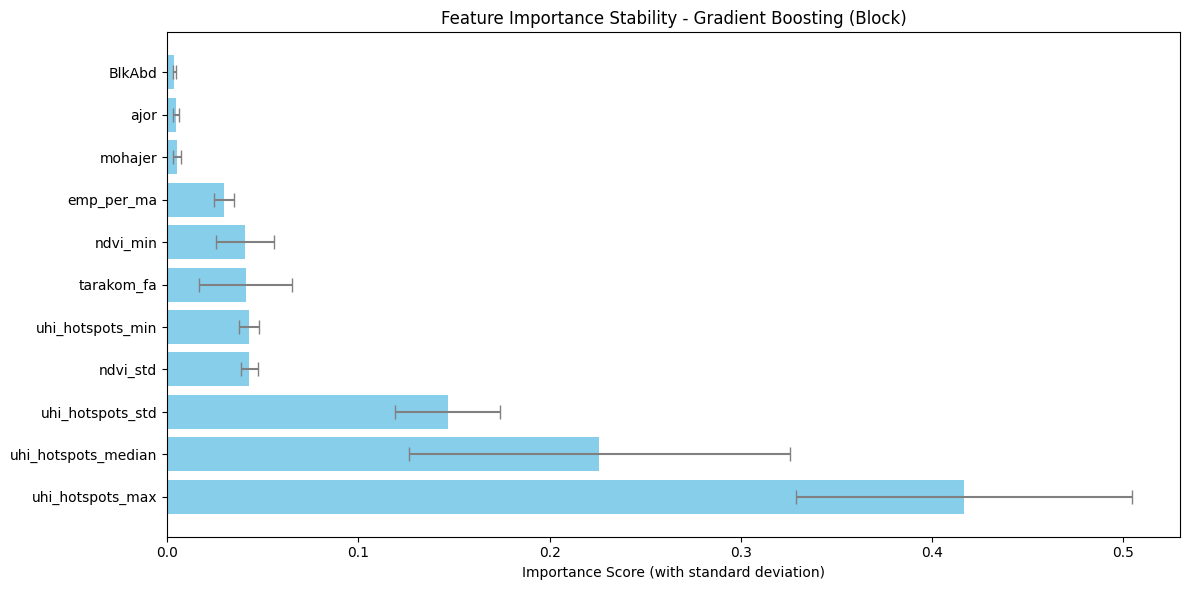


Analyzing Neighborhood scale...
Selected features: ['Shape_Leng', 'dnsty_valu', 'ajor', 'area_hec_b']

Model: Linear Regression, Scale: Neighborhood
Cross-validation Results:
CV R² Score: -3.8478 (±5.3678)
CV MSE: 3.3396 (±1.1181)

Test Set Results:
Test MSE: 1.3809
Test R² Score: 0.3786

Future Data Results:
Future MSE: 2.1028
Future R² Score: 0.1963


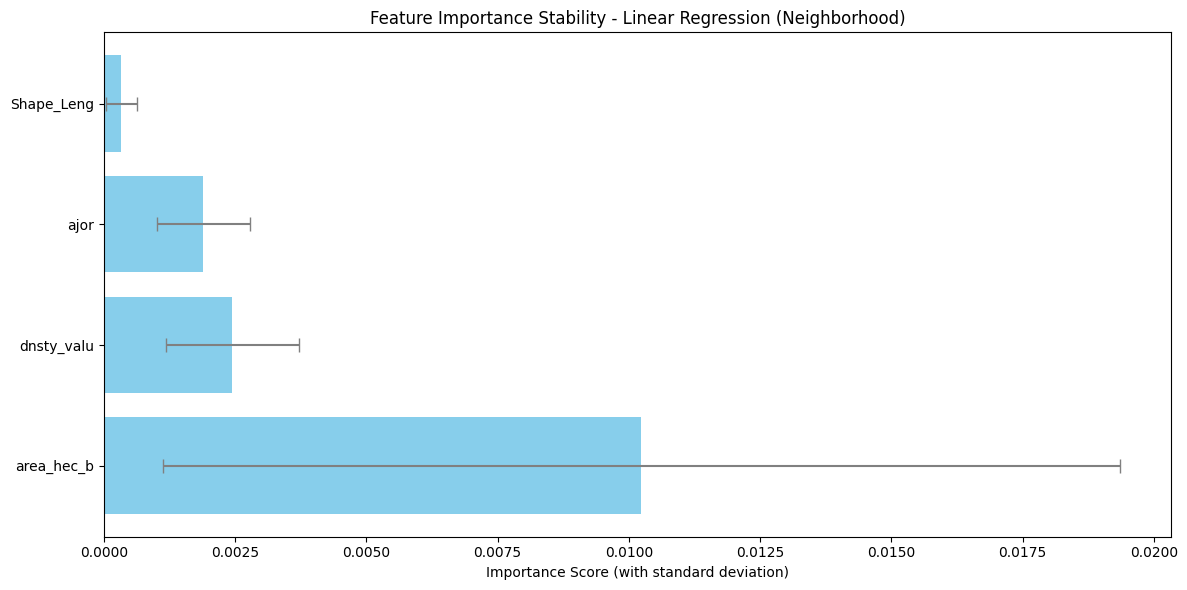


Model: Random Forest, Scale: Neighborhood
Cross-validation Results:
CV R² Score: -3.7799 (±5.9457)
CV MSE: 3.0295 (±1.4454)

Test Set Results:
Test MSE: 2.4974
Test R² Score: -0.1237

Future Data Results:
Future MSE: 1.8662
Future R² Score: 0.2867


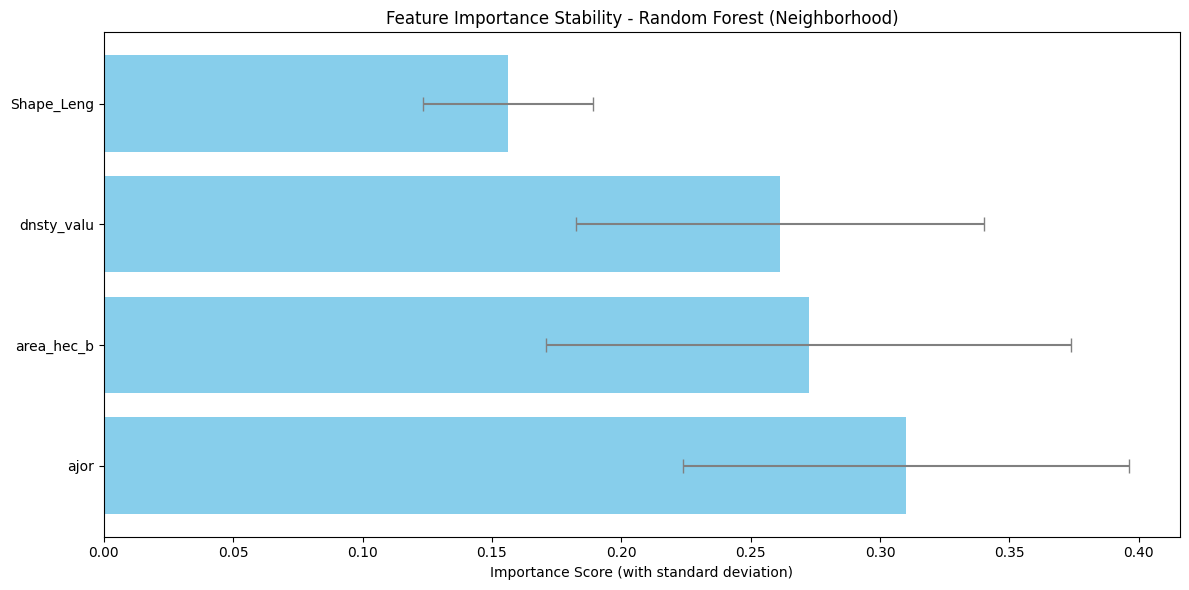


Model: XGBoost, Scale: Neighborhood
Cross-validation Results:
CV R² Score: -1.3705 (±2.0516)
CV MSE: 2.3124 (±1.9806)

Test Set Results:
Test MSE: 2.7091
Test R² Score: -0.2190

Future Data Results:
Future MSE: 1.9054
Future R² Score: 0.2718


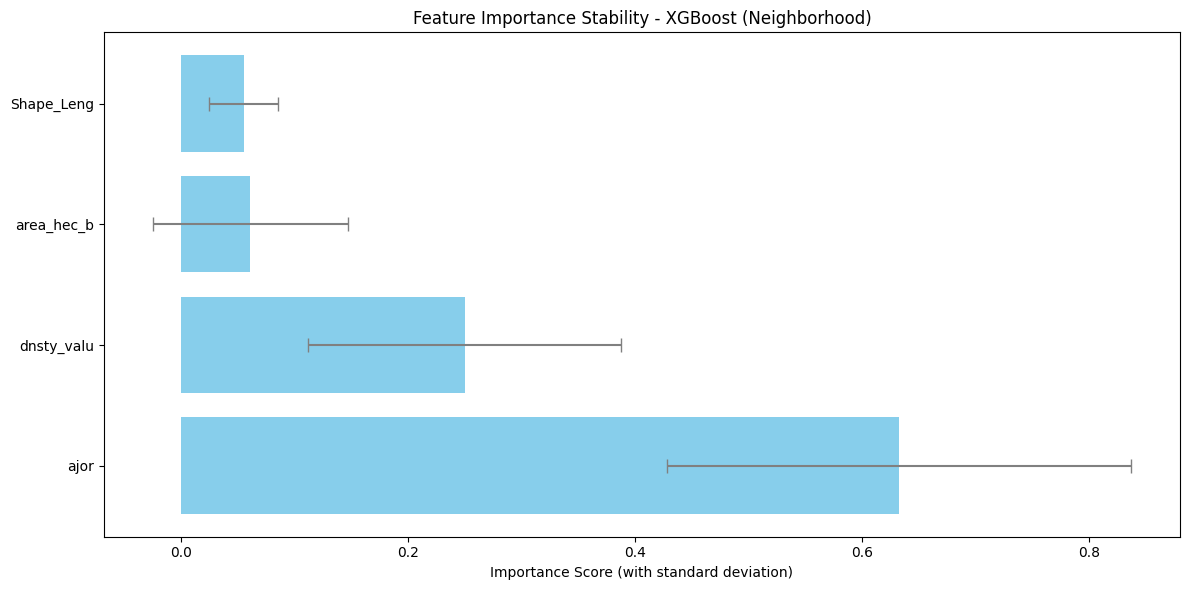


Model: Gradient Boosting, Scale: Neighborhood
Cross-validation Results:
CV R² Score: -3.5245 (±4.4376)
CV MSE: 2.7229 (±0.9268)

Test Set Results:
Test MSE: 5.3095
Test R² Score: -1.3890

Future Data Results:
Future MSE: 3.1236
Future R² Score: -0.1938


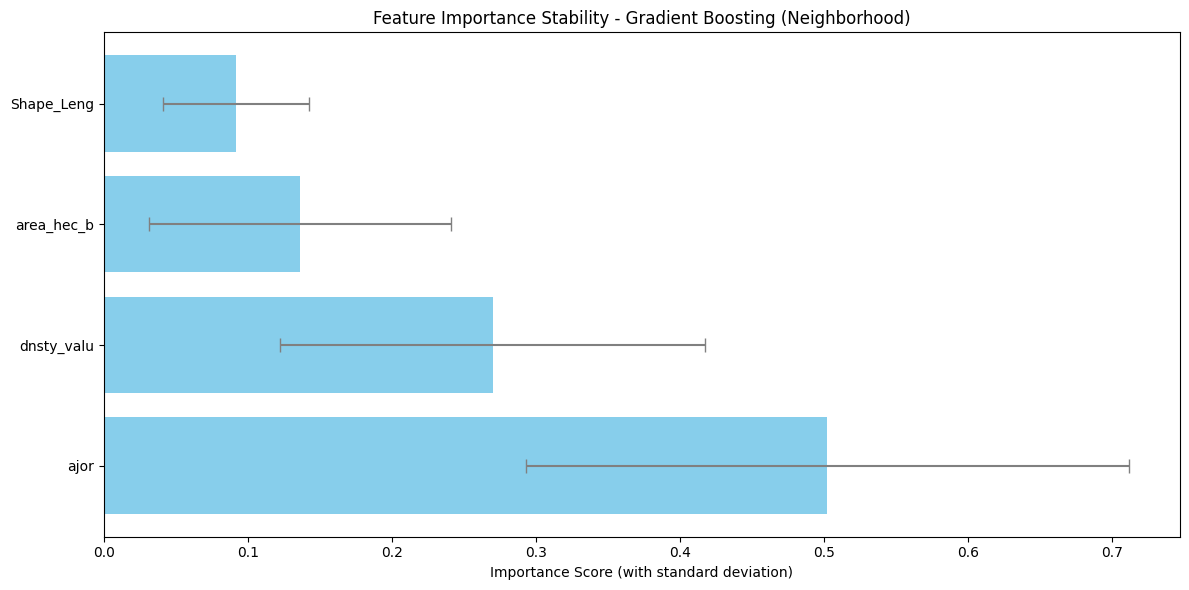

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_vif(gdf, scale_name):
    """
    Calculate VIF with proper handling of missing and infinite values.
    """
    # Select numerical columns only
    X = gdf.select_dtypes(include=[np.number])
    
    # Remove the target variable if it exists
    if 'uhi_intensity_mean' in X.columns:
        X = X.drop('uhi_intensity_mean', axis=1)
    
    # Handle missing and infinite values
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean())
    
    # Standardize the features
    X_scaled = (X - X.mean()) / X.std()
    
    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
    
    print(f"\nVIF Results for {scale_name} scale:")
    print(vif_data)
    
    # Filter features based on VIF threshold
    selected_features = vif_data[vif_data['VIF'] <= 20]['Feature'].tolist()
    
    return selected_features

def feature_importance_stability(model, X, y, n_iterations=10):
    """
    Analyze feature importance stability across multiple iterations.
    """
    importance_scores = []
    
    for _ in range(n_iterations):
        # Randomly sample 80% of the data
        indices = np.random.choice(len(X), size=int(0.8 * len(X)), replace=False)
        X_sample = X.iloc[indices]
        y_sample = y.iloc[indices]
        
        # Fit model and calculate importance
        model.fit(X_sample, y_sample)
        
        if hasattr(model, 'feature_importances_'):
            importance_scores.append(model.feature_importances_)
        elif hasattr(model, 'coef_'):
            importance_scores.append(np.abs(model.coef_))
    
    # Calculate stability metrics
    importance_df = pd.DataFrame(importance_scores, columns=X.columns)
    stability_metrics = pd.DataFrame({
        'Feature': X.columns,
        'Mean_Importance': importance_df.mean(),
        'Std_Importance': importance_df.std(),
        'CV': (importance_df.std() / importance_df.mean() * 100).fillna(0)
    }).sort_values('Mean_Importance', ascending=False)
    
    return stability_metrics

def evaluate_model(model, X_train, y_train, X_test, y_test, X_future, y_future, model_name, scale_name):
    """
    Enhanced model evaluation with cross-validation and feature importance stability.
    """
    # Cross-validation setup
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform cross-validation
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    cv_mse_scores = -cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    
    # Train the model on the full training set
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_future_pred = model.predict(X_future)
    
    # Calculate metrics
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    future_mse = mean_squared_error(y_future, y_future_pred)
    future_r2 = r2_score(y_future, y_future_pred)
    
    # Feature importance stability analysis
    stability_metrics = feature_importance_stability(model, X_train, y_train)
    
    # Print results
    print(f"\nModel: {model_name}, Scale: {scale_name}")
    print("Cross-validation Results:")
    print(f"CV R² Score: {cv_r2_scores.mean():.4f} (±{cv_r2_scores.std():.4f})")
    print(f"CV MSE: {cv_mse_scores.mean():.4f} (±{cv_mse_scores.std():.4f})")
    print("\nTest Set Results:")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R² Score: {test_r2:.4f}")
    print("\nFuture Data Results:")
    print(f"Future MSE: {future_mse:.4f}")
    print(f"Future R² Score: {future_r2:.4f}")
    
    # Visualize feature importance stability
    plt.figure(figsize=(12, 6))
    x_values = stability_metrics['Mean_Importance']
    y_values = stability_metrics['Feature']
    err_values = stability_metrics['Std_Importance']
    # Create horizontal barplot with error bars
    plt.barh(range(len(y_values)), x_values,
             xerr=err_values,
             capsize=5,
             color='skyblue',
             error_kw={'ecolor': 'gray', 'capthick': 1})
    plt.yticks(range(len(y_values)), y_values)
    plt.title(f"Feature Importance Stability - {model_name} ({scale_name})")
    plt.xlabel("Importance Score (with standard deviation)")
    plt.tight_layout()
    plt.show()
    


    return {
        'cv_r2_mean': cv_r2_scores.mean(),
        'cv_r2_std': cv_r2_scores.std(),
        'cv_mse_mean': cv_mse_scores.mean(),
        'cv_mse_std': cv_mse_scores.std(),
        'test_mse': test_mse,
        'test_r2': test_r2,
        'future_mse': future_mse,
        'future_r2': future_r2,
        'feature_stability': stability_metrics
    }

def analyze_all_scales_vif(merged_result, neighborhoods_final):
    """
    Analyze VIF for all scales with proper data cleaning.
    """
    datasets = {
        'Block': merged_result,
        'Neighborhood': neighborhoods_final
    }
    
    vif_results = {}
    for scale_name, dataset in datasets.items():
        print(f"\nCalculating VIF for {scale_name} scale...")
        vif_results[scale_name] = calculate_vif(dataset, scale_name)
    
    return vif_results

def analyze_all_scales_ml(merged_result, neighborhoods_final, vif_results):
    """
    Enhanced analysis across all scales with improved evaluation metrics.
    """
    datasets = {
        'Block': merged_result,
        'Neighborhood': neighborhoods_final
    }
    
    all_results = {}
    
    for scale_name, dataset in datasets.items():
        print(f"\nAnalyzing {scale_name} scale...")
        
        # Get selected features
        selected_features = vif_results[scale_name]
        print(f"Selected features: {selected_features}")
        
        # Prepare data
        X = dataset[selected_features]
        y = dataset['uhi_intensity_mean']
        
        # Handle missing values
        X = X.fillna(X.mean())
        y = y.fillna(y.mean())
        
        # Split data
        X_current, X_future, y_current, y_future = train_test_split(X, y, test_size=0.5, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X_current, y_current, test_size=0.2, random_state=42)
        
        models = {
            "Linear Regression": LinearRegression(),
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
            "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
            "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
        }
        
        scale_results = {}
        for model_name, model in models.items():
            scale_results[model_name] = evaluate_model(
                model, X_train, y_train, X_test, y_test, 
                X_future, y_future, model_name, scale_name
            )
        
        all_results[scale_name] = scale_results
        
        # Save results to CSV
        results_df = pd.DataFrame()
        for model_name, results in scale_results.items():
            model_metrics = {
                'Model': model_name,
                'CV_R2_Mean': results['cv_r2_mean'],
                'CV_R2_Std': results['cv_r2_std'],
                'CV_MSE_Mean': results['cv_mse_mean'],
                'CV_MSE_Std': results['cv_mse_std'],
                'Test_R2': results['test_r2'],
                'Test_MSE': results['test_mse'],
                'Future_R2': results['future_r2'],
                'Future_MSE': results['future_mse']
            }
            results_df = pd.concat([results_df, pd.DataFrame([model_metrics])], ignore_index=True)
        
        results_df.to_csv(f'{scale_name.lower()}_model_results.csv', index=False)
    
    return all_results

# Example usage
vif_results = analyze_all_scales_vif(merged_result, neighborhoods_final)
all_results = analyze_all_scales_ml(merged_result, neighborhoods_final, vif_results)